# Import Data files


In [37]:
from google.colab import drive
drive.mount('/content/drive')
 #set path to import data files
file_path1 = '/content/drive/[SET PATH]/VECTOR_ISS.txt'
file_path2 = '/content/drive/{SET PATH}/ORBITAL_ELEMENTS_FINAL.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# trim Data

In [38]:
import pandas as pd

#condense the vector data
df = pd.read_csv(file_path1, delimiter=',', header=None)
df = df.iloc[:, 3:9]
df.columns = ['X (km)', 'Y (km)', 'Z (km)', 'dX (km/s)', 'dY (km/s)', 'dZ (km/s)']

#condense the orbital element data
df2 = pd.read_csv(file_path2, delimiter=',')
df2 = df2.iloc[:, 4:7]
df2.columns = ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']

#combine data
vector_cols = df[['X (km)', 'Y (km)', 'Z (km)', 'dX (km/s)', 'dY (km/s)', 'dZ (km/s)']]
orbital_elements_cols = df2[['IN (deg)', 'RAAN (deg)', 'AoP (deg)']]
combined_data = pd.concat([vector_cols, orbital_elements_cols], axis=1)


# Visualize Data


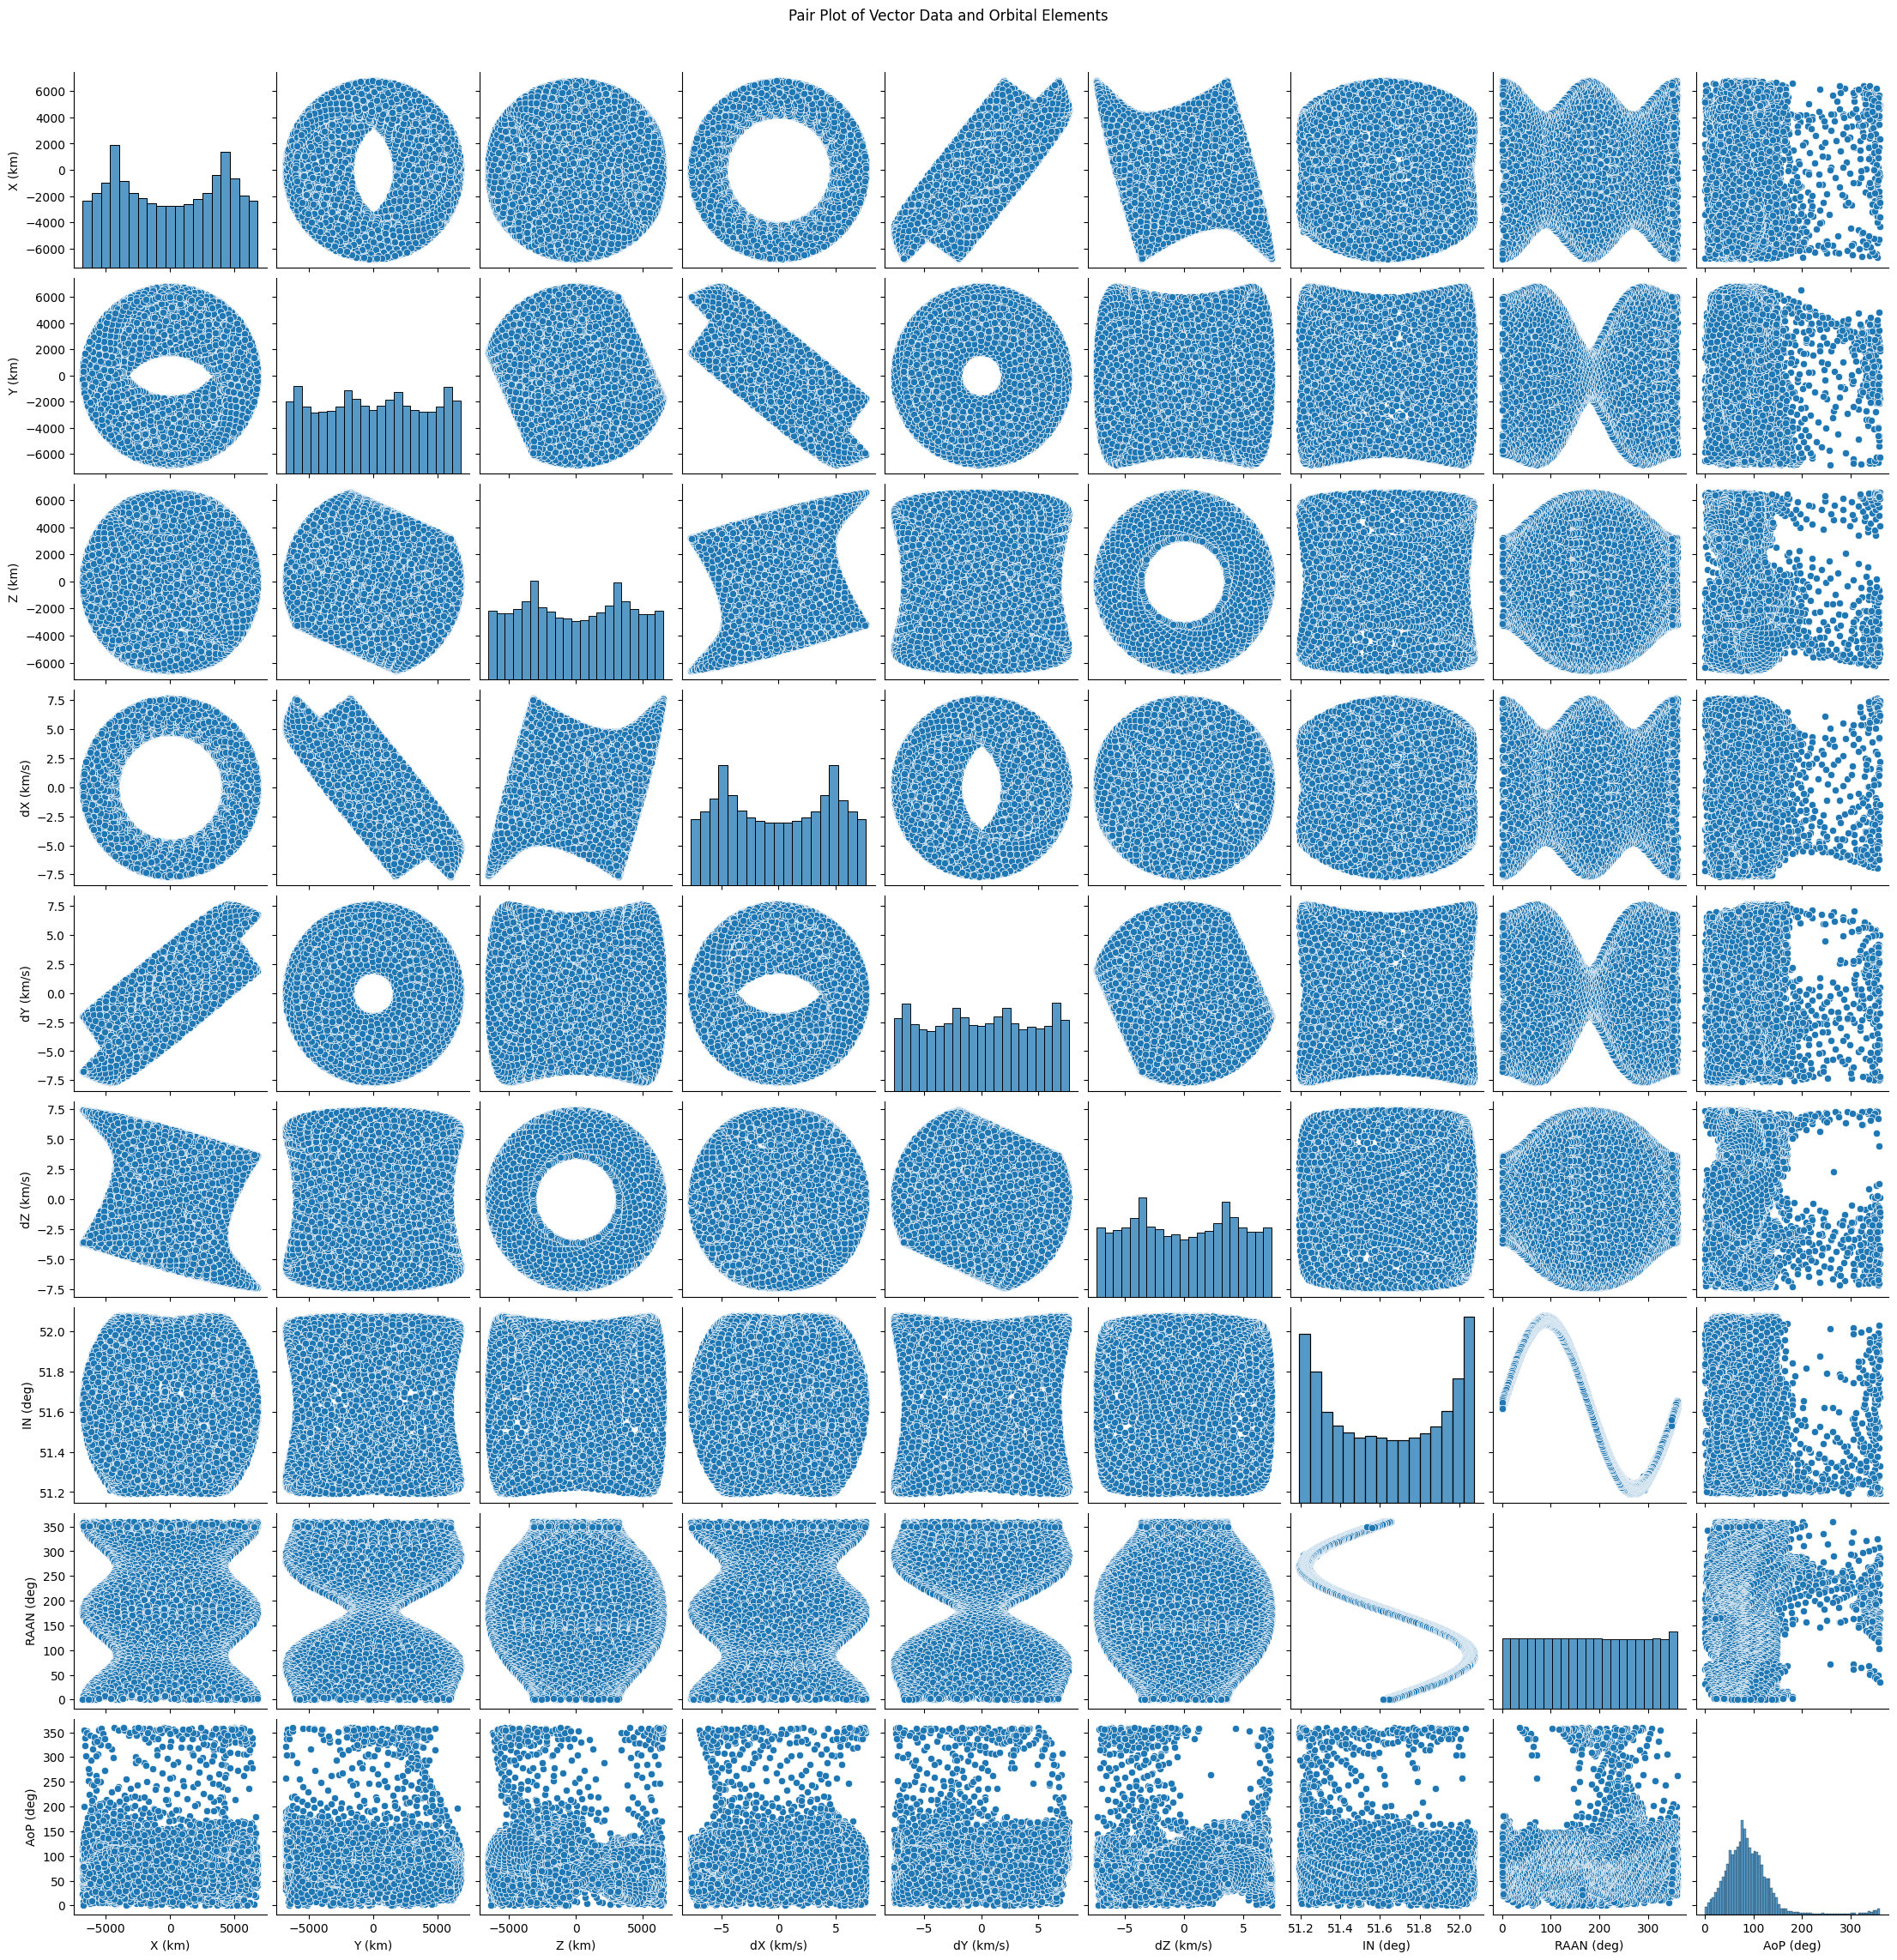

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(combined_data)
plt.suptitle('Pair Plot of Vector Data and Orbital Elements', y=1.02)
plt.show()

# Pre-process Data

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
df2.dropna(inplace=True)
combined_data_cleaned = combined_data.dropna()
X = combined_data_cleaned[['X (km)', 'Y (km)', 'Z (km)', 'dX (km/s)', 'dY (km/s)', 'dZ (km/s)']].values
y = combined_data_cleaned[['IN (deg)', 'RAAN (deg)', 'AoP (deg)']].values

# Standard scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# reshape
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])

# train-test-split with 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Case 1 Model + results

Case 1 model: LSTM Layer w/ 50 neurons,
Dense Layer w/ 3 neurons

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Case 1 model
case1 = Sequential()
case1.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
case1.add(Dense(units=3))
case1.compile(optimizer='adam', loss='mse')
case1.fit(X_train, y_train, epochs=50, batch_size=32)

#training
history = case1.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9879
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0080
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0236
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0174
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0117
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9972
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0316
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9917
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0041
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9871
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9962
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9971
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9829
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9924
Epoch 15/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0009


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


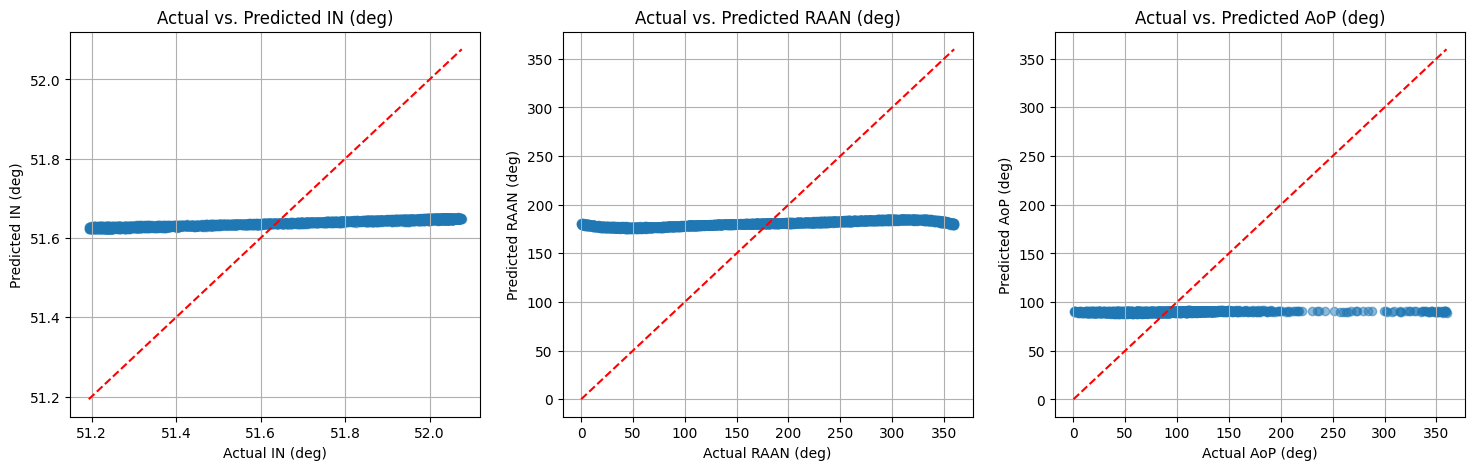

In [42]:
import numpy as np

#predict
y_pred = case1.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_inv = scaler_y.inverse_transform(y_pred)

features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
fig, axes = plt.subplots(1, y_test_inv.shape[1], figsize=(18, 5))

# Plot actual vs. predictions
for i in range(y_test_inv.shape[1]):
    axes[i].scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5)
    axes[i].set_xlabel(f'Actual {features[i]}')
    axes[i].set_ylabel(f'Predicted {features[i]}')
    axes[i].set_title(f'Actual vs. Predicted {features[i]}')
    axes[i].plot([min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 [min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 color='red', linestyle='--') # y=x line
    axes[i].grid(True)


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Case 1 results \n")

# find results
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{feature}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

Case 1 results 

IN (deg)
MAE: 0.2577
RMSE: 0.2875
R-squared: 0.0544

RAAN (deg)
MAE: 88.9051
RMSE: 102.6835
R-squared: 0.0446

AoP (deg)
MAE: 34.1547
RMSE: 50.6402
R-squared: 0.0097



# Case 2 Model and results


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Case 2 model
case2 = Sequential()
case2.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
case2.add(Dense(units=3))
case2.compile(optimizer='adam', loss='mse')
case2.fit(X_train, y_train, epochs=50, batch_size=32)

#training
history = case2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9689
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0362
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9753
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9977
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0443
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0243
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0007
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9922
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0114
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0152
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9985
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0074
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0057
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0173
Epoch 15/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0255


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


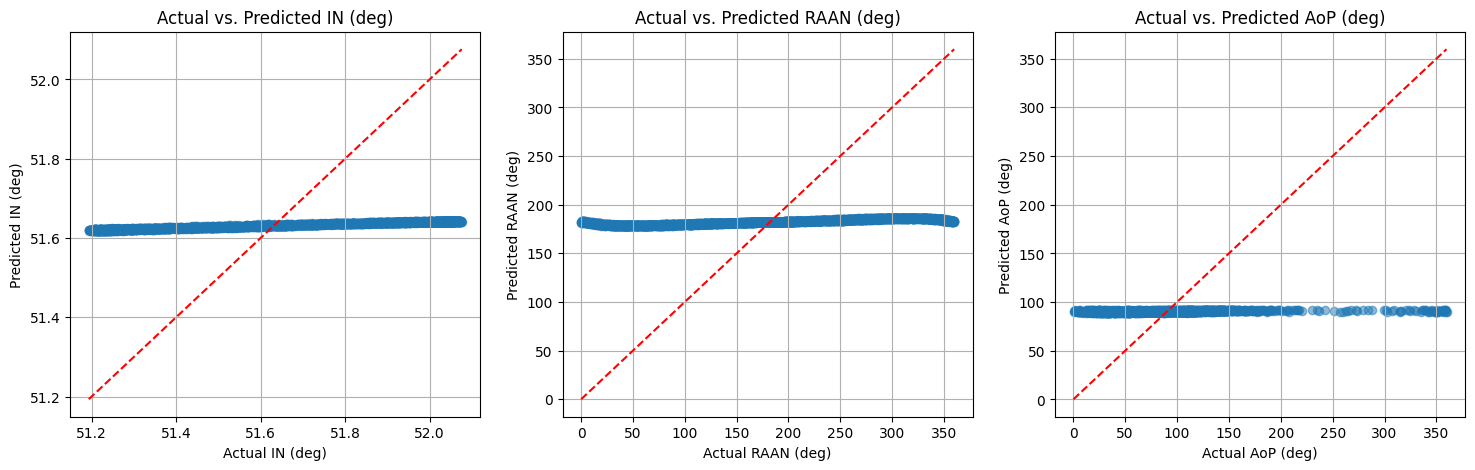

In [45]:
import numpy as np

#predict
y_pred = case2.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_inv = scaler_y.inverse_transform(y_pred)

features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
fig, axes = plt.subplots(1, y_test_inv.shape[1], figsize=(18, 5))

# Plot actual vs. predictions
for i in range(y_test_inv.shape[1]):
    axes[i].scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5)
    axes[i].set_xlabel(f'Actual {features[i]}')
    axes[i].set_ylabel(f'Predicted {features[i]}')
    axes[i].set_title(f'Actual vs. Predicted {features[i]}')
    axes[i].plot([min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 [min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 color='red', linestyle='--') # y=x line
    axes[i].grid(True)

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Case 2 results \n")

# find results
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{feature}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

Case 2 results 

IN (deg)
MAE: 0.2582
RMSE: 0.2881
R-squared: 0.0502

RAAN (deg)
MAE: 89.0900
RMSE: 102.9498
R-squared: 0.0397

AoP (deg)
MAE: 34.2539
RMSE: 50.6483
R-squared: 0.0093



# Case 3 model + results

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Case 3 model
case3 = Sequential()
case3.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
case3.add(Dense(units=50, activation='relu'))
case3.add(Dense(units=3))
case3.compile(optimizer='adam', loss='mse')
case3.fit(X_train, y_train, epochs=50, batch_size=32)

#training
history = case3.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8199
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4111
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3809
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3363
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3158
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3029
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2809
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2578
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2846
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2672
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2672
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2990
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2756
Epoch 15/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


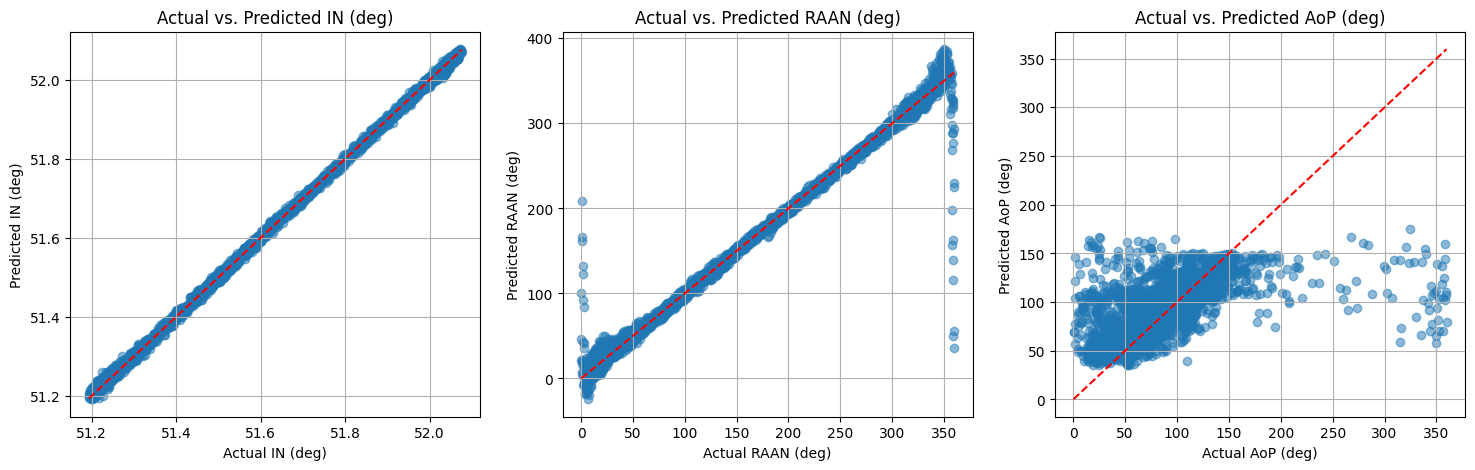

In [59]:
import numpy as np

#predict
y_pred = case3.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
fig, axes = plt.subplots(1, y_test_inv.shape[1], figsize=(18, 5))

# Plot actual vs. predictions
for i in range(y_test_inv.shape[1]):
    axes[i].scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5)
    axes[i].set_xlabel(f'Actual {features[i]}')
    axes[i].set_ylabel(f'Predicted {features[i]}')
    axes[i].set_title(f'Actual vs. Predicted {features[i]}')
    axes[i].plot([min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 [min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 color='red', linestyle='--') # y=x line
    axes[i].grid(True)

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Case 3 results \n")

# find results
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{feature}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

Case 3 results 

IN (deg)
MAE: 0.0063
RMSE: 0.0080
R-squared: 0.9993

RAAN (deg)
MAE: 5.7430
RMSE: 17.9055
R-squared: 0.9710

AoP (deg)
MAE: 25.8359
RMSE: 44.0784
R-squared: 0.2497



# Case 4 model + results

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Case 4 model
case4 = Sequential()
case4.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
case4.add(Dense(units=50, activation='relu'))
case4.add(Dense(units=50, activation='relu'))
case4.add(Dense(units=3))
case4.compile(optimizer='adam', loss='mse')
case4.fit(X_train, y_train, epochs=50, batch_size=32)

#training
history = case4.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7526
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3850
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3264
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3354
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3005
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2803
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2949
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2720
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2791
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2688
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2720
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2649
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2706
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2812
Epoch 15/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


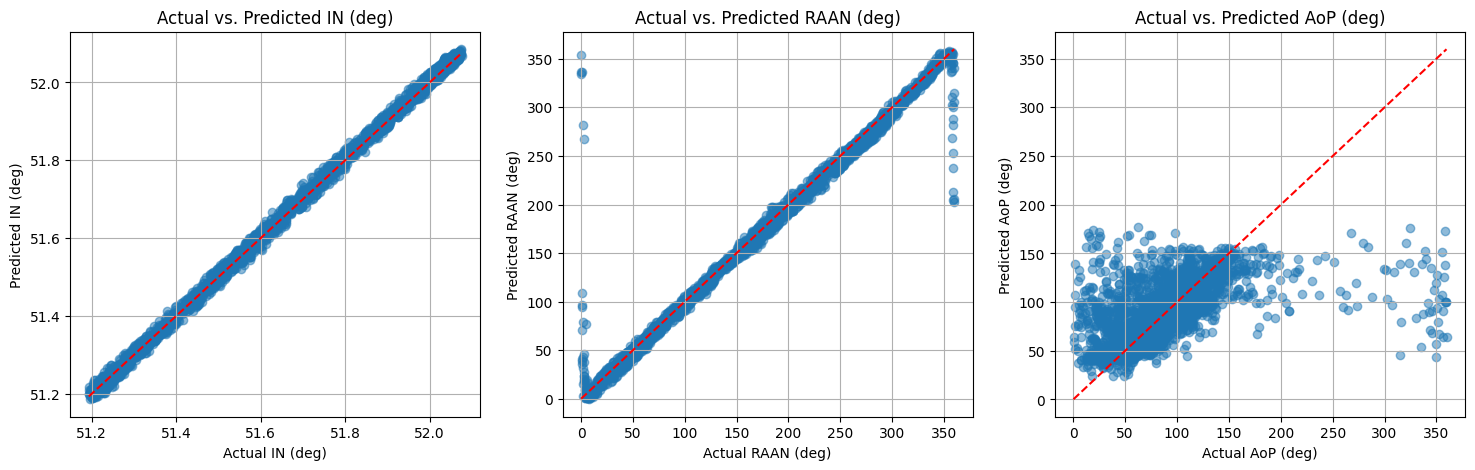

In [62]:
import numpy as np

#predict
y_pred = case4.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
fig, axes = plt.subplots(1, y_test_inv.shape[1], figsize=(18, 5))

# Plot actual vs. predictions
for i in range(y_test_inv.shape[1]):
    axes[i].scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5)
    axes[i].set_xlabel(f'Actual {features[i]}')
    axes[i].set_ylabel(f'Predicted {features[i]}')
    axes[i].set_title(f'Actual vs. Predicted {features[i]}')
    axes[i].plot([min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 [min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 color='red', linestyle='--') # y=x line
    axes[i].grid(True)

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Case 4 results \n")

# find results
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{feature}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

Case 4 results 

IN (deg)
MAE: 0.0097
RMSE: 0.0123
R-squared: 0.9983

RAAN (deg)
MAE: 5.4312
RMSE: 18.3796
R-squared: 0.9694

AoP (deg)
MAE: 25.8631
RMSE: 44.6925
R-squared: 0.2286



# Case 5 model +results

In [66]:
#Case 5 model
case5 = Sequential()
case5.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
case5.add(Dense(units=50, activation='relu'))
case5.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
case5.add(Dense(units=3))
case5.compile(optimizer='adam', loss='mse')
case5.fit(X_train, y_train, epochs=50, batch_size=32)

#training
history = case5.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0027
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0113
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9990
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9979
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0206
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0161
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0123
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9994
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9742
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0101
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9953
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0176
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9997
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9996
Epoch 15/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


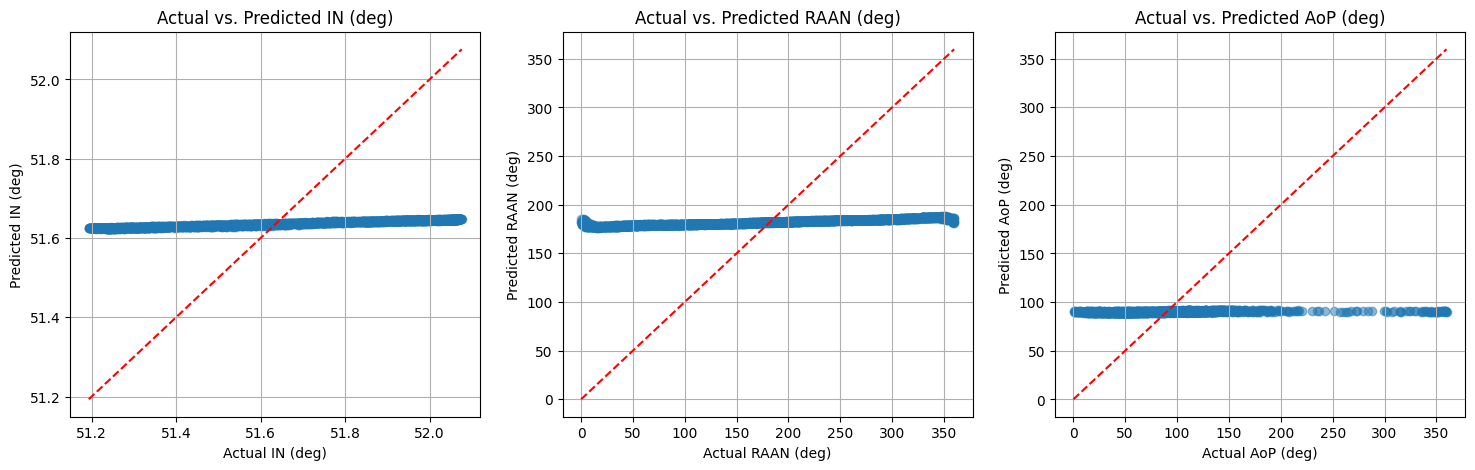

In [67]:
import numpy as np

#predict
y_pred = case5.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

features= ['IN (deg)', 'RAAN (deg)', 'AoP (deg)']
fig, axes = plt.subplots(1, y_test_inv.shape[1], figsize=(18, 5))

# Plot actual vs. predictions
for i in range(y_test_inv.shape[1]):
    axes[i].scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5)
    axes[i].set_xlabel(f'Actual {features[i]}')
    axes[i].set_ylabel(f'Predicted {features[i]}')
    axes[i].set_title(f'Actual vs. Predicted {features[i]}')
    axes[i].plot([min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 [min(y_test_inv[:, i]), max(y_test_inv[:, i])],
                 color='red', linestyle='--') # y=x line
    axes[i].grid(True)

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Case 5 results \n")

# find results
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{feature}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

Case 5 results 

IN (deg)
MAE: 0.2580
RMSE: 0.2879
R-squared: 0.0516

RAAN (deg)
MAE: 88.7840
RMSE: 102.4558
R-squared: 0.0489

AoP (deg)
MAE: 34.1374
RMSE: 50.6197
R-squared: 0.0105

